In [62]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, DATE, cast

In [66]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [67]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [68]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [69]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [89]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()

columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])
print('******************************')
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
******************************
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

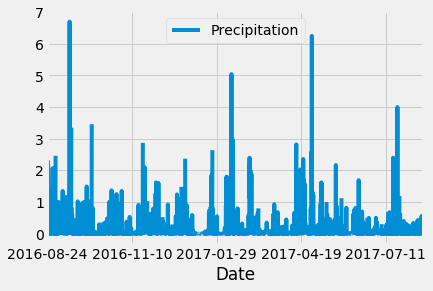

In [71]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

maxdate = session.query(func.max(Measurement.date)).all()
max_date = dt.datetime.strptime(maxdate[0][0], '%Y-%m-%d')
max_minus_year = max_date - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= max_minus_year).all()
ppt_df = pd.DataFrame(results, columns=["Date", "Precipitation"])
ppt_df.set_index(["Date"], inplace = True, drop = True)
ppt_df.sort_index(inplace=True)
ppt_df.plot()
plt.legend(loc = 'upper center')
plt.show()

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ppt_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [73]:
# Design a query to show how many stations are available in this dataset?
results = session.query(func.count(Station.station)).all()
results

[(9)]

In [74]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station)).\
          group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').all()

results

[(54.0, 85.0, 71.66378066378067)]

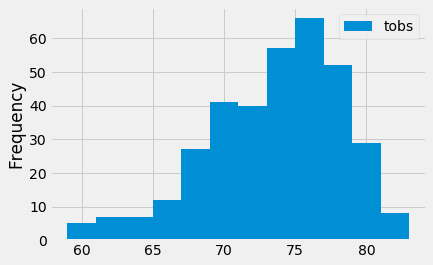

In [76]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.station, func.count(Measurement.tobs)).\
          filter(Measurement.tobs is not None).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

results1 = session.query(Measurement.tobs).\
          filter(Measurement.station == results[0][0]).filter(Measurement.date >= max_minus_year).all()

r1 = [i[0] for i in results1]

plt.hist(r1, bins = 12)
plt.ylabel("Frequency")
lgnd=['tobs']
plt.legend(lgnd)
plt.show()


![precipitation](Images/station-histogram.png)

In [77]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [78]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-12-14'
trip_end = '2016-12-21'

trip_start_earlier = dt.datetime.strptime(trip_start, '%Y-%m-%d') - dt.timedelta(days=365)
trip_end_earlier = dt.datetime.strptime(trip_end, '%Y-%m-%d') - dt.timedelta(days=365)

results = calc_temps(trip_start_earlier, trip_end_earlier)[0]

print(f"{results[0]} {results[1]} {results[2]}")

68.0 74.47619047619048 82.0


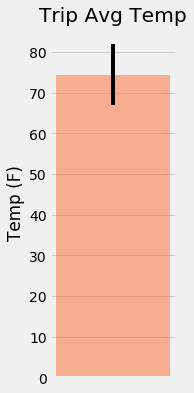

In [79]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=[2,6])
plt.bar(x=0, height=results[1], yerr=(results[2]-results[1]), color = 'coral', alpha=.6)
plt.grid(axis='x')
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.show()

In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
                  join(Measurement,Measurement.station == Station.station).\
                  filter(Measurement.date >= trip_start_earlier ).\
                  filter(Measurement.date <= trip_end_earlier ).\
                  group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                  order_by(func.sum(Measurement.prcp).desc()).all()

rainfalldf = pd.DataFrame(rainfall, columns=["Station", "Station Name", "Latitude","Longitude","Elevation", "Precipitation"])
rainfalldf


,Station,Station Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.71
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.09
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.66
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.57
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.46
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.27
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.11


## Optional Challenge Assignment

In [81]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [82]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_start = '2016-12-14'
trip_end = '2016-12-21'

trip_start_date = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_end_date = dt.datetime.strptime(trip_end, "%Y-%m-%d")

date_range = []

while (trip_end_date >= trip_start_date):
    date_range.append(dt.datetime.strftime(trip_start_date, '%Y-%m-%d'))
    trip_start_date += dt.timedelta(days=1)
    
values = []

for i in date_range:
    val = i[5:]
    values.append(daily_normals(val)[0])
    
values

[(65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0)]

In [83]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
pd_values = pd.DataFrame(values, columns = ['TMin', 'TAvg', 'TMax'])

pd_values = pd_values.assign(Date = date_range)

pd_values.set_index(["Date"], inplace = True, drop = True)

print(pd_values)

            TMin       TAvg  TMax
Date                             
2016-12-14  65.0  71.180000  78.0
2016-12-15  62.0  71.340000  79.0
2016-12-16  60.0  69.622642  82.0
2016-12-17  63.0  70.640000  77.0
2016-12-18  63.0  71.280000  77.0
2016-12-19  67.0  72.000000  78.0
2016-12-20  65.0  72.913043  81.0
2016-12-21  67.0  72.139535  78.0


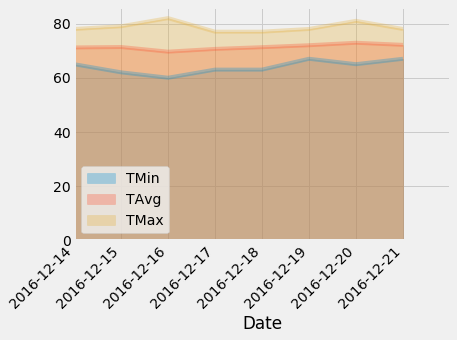

In [84]:
# Plot the daily normals as an area plot with `stacked=False`
ticks = np.arange(0,9)

pd_values.plot.area(stacked=False, alpha = .3)
plt.xticks(ticks, date_range, rotation = 45, horizontalalignment = 'right')
plt.xlabel('Date')
plt.show()